<a href="https://colab.research.google.com/github/olvhnk/AD599-Final-Project/blob/main/Final_Project_Oliver_Hancock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Head of feature table:
   student_id    student_name  avg_assignment_score  min_assignment_score  \
0           1    William Hill             64.577730             50.000000   
1           2  Johnny Gilbert             69.670862             46.045451   
2           3   Jesse Rodgers             66.363522             50.000000   
3           4     John Gibson             64.597840             49.865888   
4           5   Anna Whitaker             68.620277             50.000000   

   max_assignment_score  num_assignment_submissions  num_late_submissions  \
0             100.00000                          57                    14   
1             100.00000                          40                     7   
2             100.00000                          51                     6   
3              95.53978                          63                    13   
4             100.00000                          37                    10   

   avg_quiz_score  min_quiz_score  max_quiz_score  

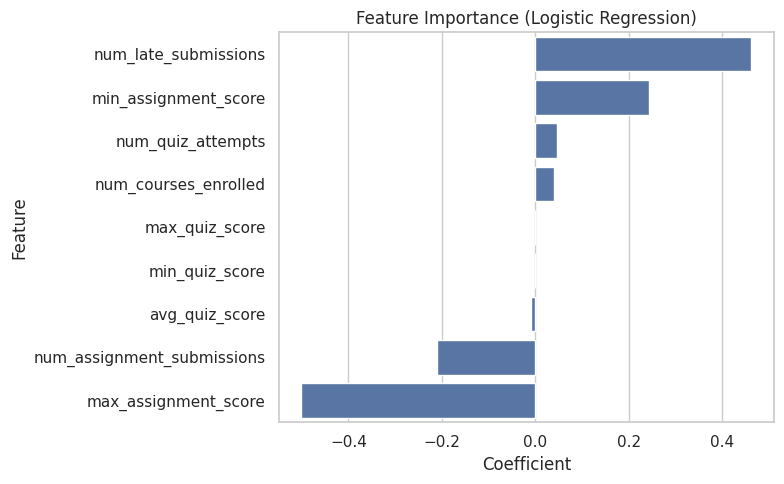

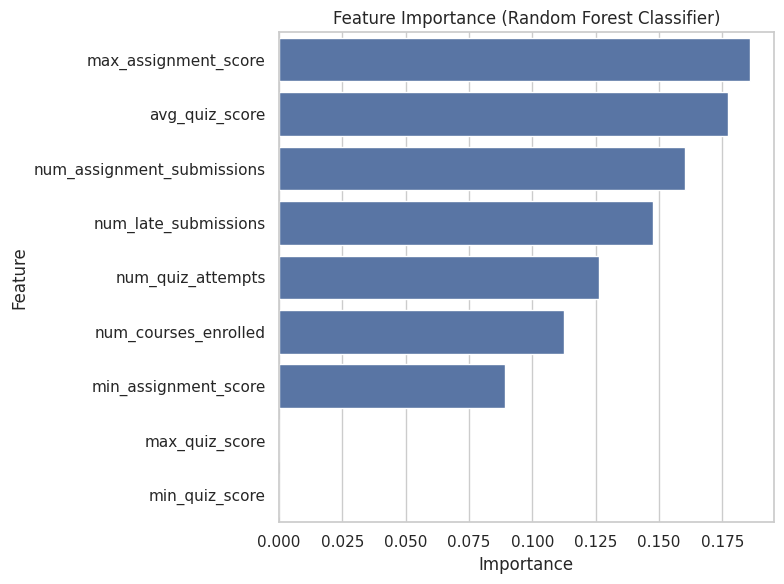

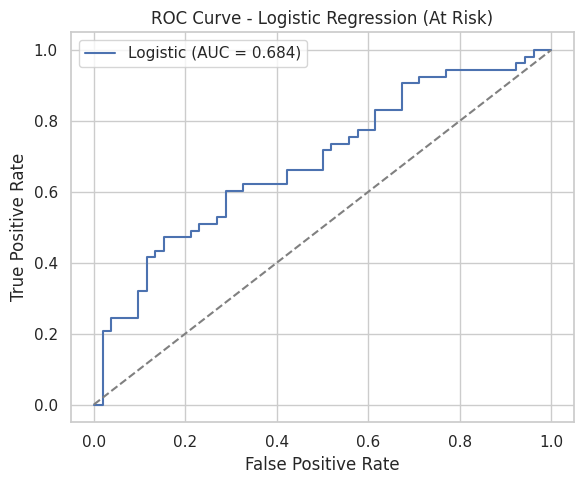

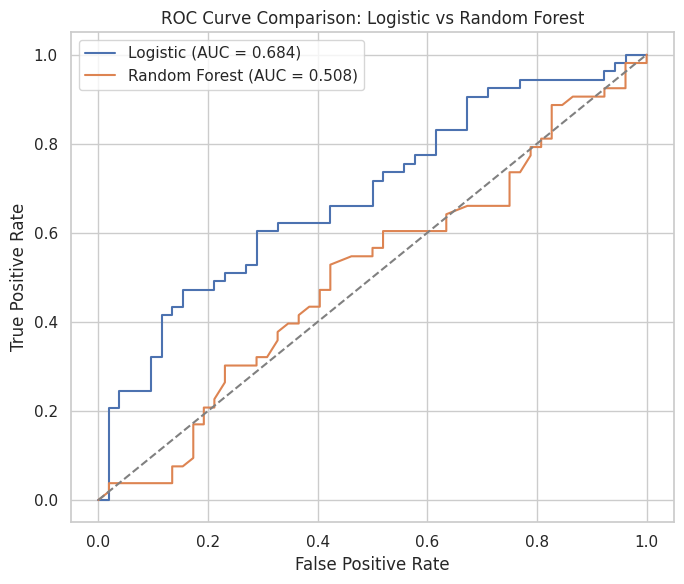

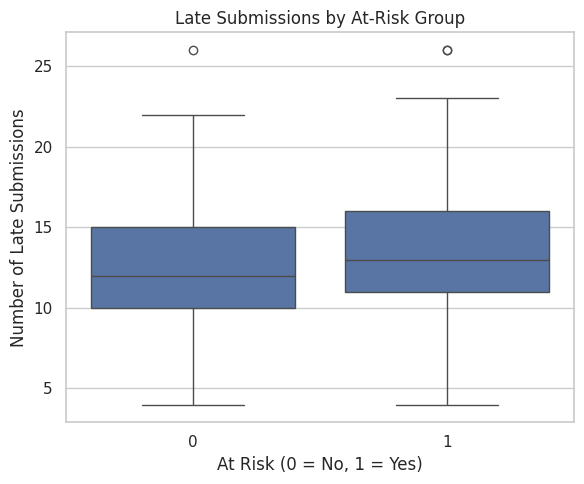

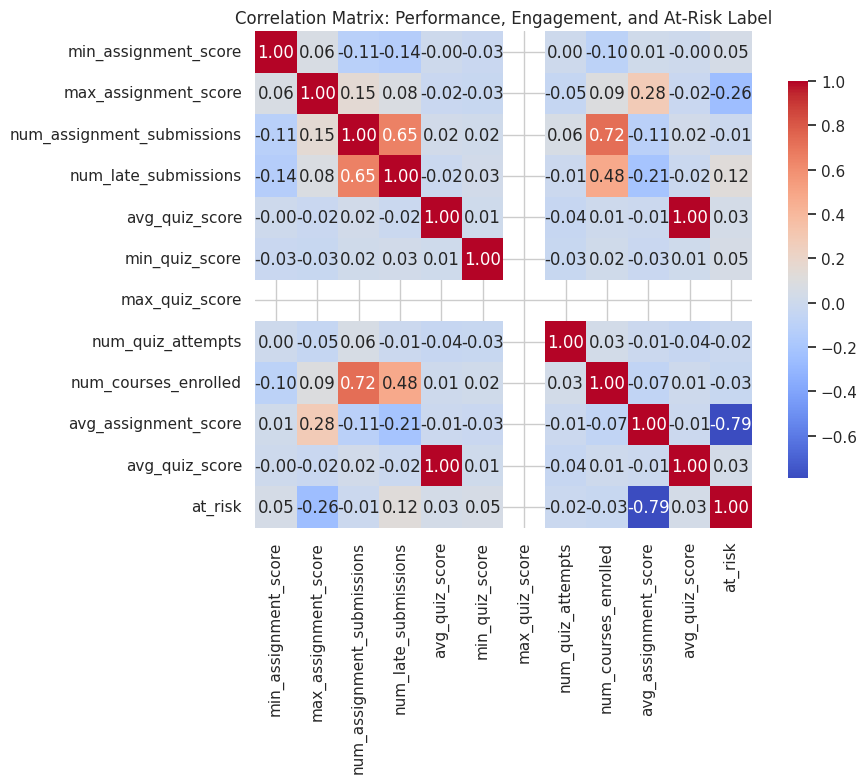

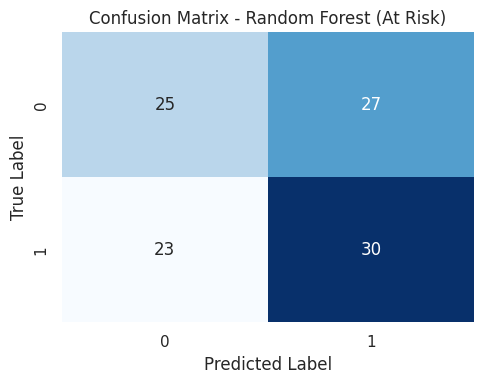

Detected date columns: ['submit_datetime']
Rows loaded: 17966
Saved time_series_assignment_scores.jpeg successfully!


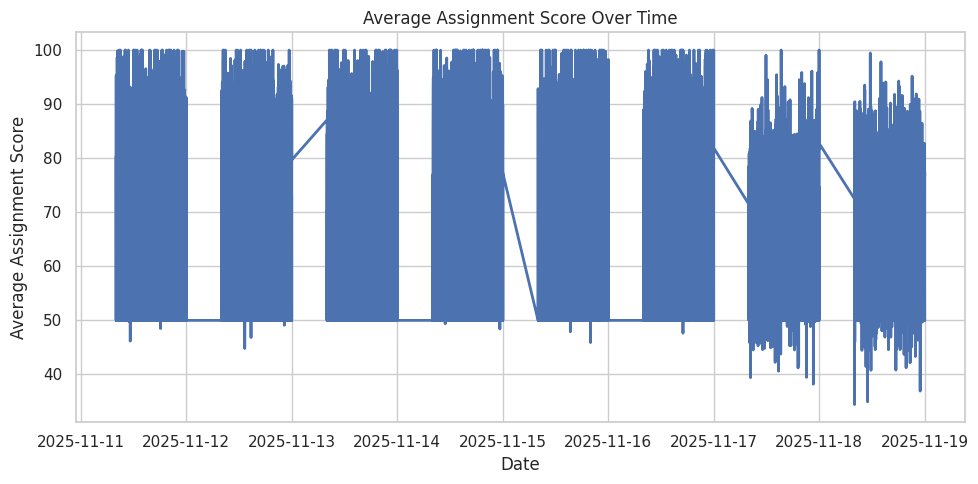


Feature table exported to lms_student_features.csv


In [3]:
" " " Task 3: Machine Learning Models for lms.db " " "

import sqlite3
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# ML / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
)

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("xgboost is not installed. Skipping XGBoost model.")
    XGBOOST_AVAILABLE = False

sns.set(style="whitegrid")

# 1. Connect to the database and build features
DB_PATH = "lms.db"
conn = sqlite3.connect(DB_PATH)

# SQLAlchemy engine
engine = create_engine(f"sqlite:///{DB_PATH}")

sql_features = """
WITH student_assignment_scores AS (
    SELECT
        s.student_id,
        AVG(s.score) AS avg_assignment_score,
        MIN(s.score) AS min_assignment_score,
        MAX(s.score) AS max_assignment_score,
        COUNT(*)     AS num_assignment_submissions,
        SUM(s.late_flag) AS num_late_submissions
    FROM submissions s
    GROUP BY s.student_id
),
student_quiz_scores AS (
    SELECT
        qs.student_id,
        AVG(qs.score) AS avg_quiz_score,
        MIN(qs.score) AS min_quiz_score,
        MAX(qs.score) AS max_quiz_score,
        COUNT(*)      AS num_quiz_attempts
    FROM quiz_scores qs
    GROUP BY qs.student_id
),
student_course_counts AS (
    SELECT
        e.student_id,
        COUNT(DISTINCT e.course_id) AS num_courses_enrolled
    FROM enrollments e
    GROUP BY e.student_id
)
SELECT
    st.student_id,
    st.name AS student_name,
    COALESCE(a.avg_assignment_score, 0) AS avg_assignment_score,
    COALESCE(a.min_assignment_score, 0) AS min_assignment_score,
    COALESCE(a.max_assignment_score, 0) AS max_assignment_score,
    COALESCE(a.num_assignment_submissions, 0) AS num_assignment_submissions,
    COALESCE(a.num_late_submissions, 0) AS num_late_submissions,
    COALESCE(q.avg_quiz_score, 0) AS avg_quiz_score,
    COALESCE(q.min_quiz_score, 0) AS min_quiz_score,
    COALESCE(q.max_quiz_score, 0) AS max_quiz_score,
    COALESCE(q.num_quiz_attempts, 0) AS num_quiz_attempts,
    COALESCE(c.num_courses_enrolled, 0) AS num_courses_enrolled
FROM students st
LEFT JOIN student_assignment_scores a
    ON st.student_id = a.student_id
LEFT JOIN student_quiz_scores q
    ON st.student_id = q.student_id
LEFT JOIN student_course_counts c
    ON st.student_id = c.student_id
"""

features_df = pd.read_sql_query(sql_features, engine)
conn.close()

print("Head of feature table:")
print(features_df.head())

# 2. Targets and Feature Matrix

df = features_df.copy()

# Drop rows missing assignment average
df = df.dropna(subset=["avg_assignment_score"])

# Classification Target (at risk = below mean score)
global_mean = df["avg_assignment_score"].mean()
df["at_risk"] = (df["avg_assignment_score"] < global_mean).astype(int)

print("\nGlobal mean assignment score:", round(global_mean, 3))
print("At risk counts (0 = not at risk, 1 = at risk):")
print(df["at_risk"].value_counts())

# Feature columns
feature_cols = [
    "min_assignment_score",
    "max_assignment_score",
    "num_assignment_submissions",
    "num_late_submissions",
    "avg_quiz_score",
    "min_quiz_score",
    "max_quiz_score",
    "num_quiz_attempts",
    "num_courses_enrolled",
]

X = df[feature_cols].fillna(0).values
y_clf = df["at_risk"].values
y_reg = df["avg_assignment_score"].values

# 3. Train / test split and scaling

# Classification split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

# Regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

# Scaling for models that need it
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# 4. Classification models (baseline + advanced)

print("\n=== Classification Models (At Risk) ===")

# Dummy classifier baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_dummy = dummy_clf.predict(X_test_clf_scaled)

acc_dummy = accuracy_score(y_test_clf, y_pred_dummy)
f1_dummy = f1_score(y_test_clf, y_pred_dummy, zero_division=0)

print("\nDummyClassifier:")
print("  Accuracy:", round(acc_dummy, 3))
print("  F1:", round(f1_dummy, 3))

# Logistic Regression
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_log = log_clf.predict(X_test_clf_scaled)
y_proba_log = log_clf.predict_proba(X_test_clf_scaled)[:, 1]

acc_log = accuracy_score(y_test_clf, y_pred_log)
f1_log = f1_score(y_test_clf, y_pred_log)
auc_log = roc_auc_score(y_test_clf, y_proba_log)

print("\nLogisticRegression:")
print("  Accuracy:", round(acc_log, 3))
print("  F1:", round(f1_log, 3))
print("  AUC:", round(auc_log, 3))

feat_importance_log = pd.Series(
    log_clf.coef_[0],
    index=feature_cols
).sort_values(ascending=False)

# Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf.predict(X_test_clf)
y_proba_rf = rf_clf.predict_proba(X_test_clf)[:, 1]

acc_rf = accuracy_score(y_test_clf, y_pred_rf)
f1_rf = f1_score(y_test_clf, y_pred_rf)
auc_rf = roc_auc_score(y_test_clf, y_proba_rf)

print("\nRandomForestClassifier:")
print("  Accuracy:", round(acc_rf, 3))
print("  F1:", round(f1_rf, 3))
print("  AUC:", round(auc_rf, 3))

rf_importance = pd.Series(
    rf_clf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print("\nRandom Forest feature importance:")
print(rf_importance)

# Support Vector Machine (SVC)
svc_clf = SVC(kernel="rbf", probability=True, random_state=42)
svc_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_svc = svc_clf.predict(X_test_clf_scaled)
y_proba_svc = svc_clf.predict_proba(X_test_clf_scaled)[:, 1]

acc_svc = accuracy_score(y_test_clf, y_pred_svc)
f1_svc = f1_score(y_test_clf, y_pred_svc)
auc_svc = roc_auc_score(y_test_clf, y_proba_svc)

print("\nSVC (Support Vector Machine):")
print("  Accuracy:", round(acc_svc, 3))
print("  F1:", round(f1_svc, 3))
print("  AUC:", round(auc_svc, 3))

# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_knn = knn_clf.predict(X_test_clf_scaled)
y_proba_knn = knn_clf.predict_proba(X_test_clf_scaled)[:, 1]

acc_knn = accuracy_score(y_test_clf, y_pred_knn)
f1_knn = f1_score(y_test_clf, y_pred_knn)
auc_knn = roc_auc_score(y_test_clf, y_proba_knn)

print("\nKNeighborsClassifier:")
print("  Accuracy:", round(acc_knn, 3))
print("  F1:", round(f1_knn, 3))
print("  AUC:", round(auc_knn, 3))

if XGBOOST_AVAILABLE:
    xgb_clf = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
    )
    xgb_clf.fit(X_train_clf, y_train_clf)
    y_pred_xgb = xgb_clf.predict(X_test_clf)
    y_proba_xgb = xgb_clf.predict_proba(X_test_clf)[:, 1]

    acc_xgb = accuracy_score(y_test_clf, y_pred_xgb)
    f1_xgb = f1_score(y_test_clf, y_pred_xgb)
    auc_xgb = roc_auc_score(y_test_clf, y_proba_xgb)

    print("\nXGBClassifier:")
    print("  Accuracy:", round(acc_xgb, 3))
    print("  F1:", round(f1_xgb, 3))
    print("  AUC:", round(auc_xgb, 3))

# 5. Regression models (predict avg_assignment_score)

print("\n=== Regression Models (Predict avg_assignment_score) ===")

# DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_dummy_reg = dummy_reg.predict(X_test_reg_scaled)

rmse_dummy = mean_squared_error(y_test_reg, y_pred_dummy_reg) ** 0.5
mae_dummy = mean_absolute_error(y_test_reg, y_pred_dummy_reg)

print("\nDummyRegressor:")
print("  RMSE:", round(rmse_dummy, 3))
print("  MAE:", round(mae_dummy, 3))

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_lin = lin_reg.predict(X_test_reg_scaled)

rmse_lin = mean_squared_error(y_test_reg, y_pred_lin) ** 0.5
mae_lin = mean_absolute_error(y_test_reg, y_pred_lin)

print("\nLinearRegression:")
print("  RMSE:", round(rmse_lin, 3))
print("  MAE:", round(mae_lin, 3))

lin_importance = pd.Series(
    lin_reg.coef_,
    index=feature_cols
).sort_values(ascending=False)

print("\nLinear Regression feature importance (coefficients):")
print(lin_importance)

# Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)

rmse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg) ** 0.5
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)

print("\nRandomForestRegressor:")
print("  RMSE:", round(rmse_rf, 3))
print("  MAE:", round(mae_rf, 3))

rf_reg_importance = pd.Series(
    rf_reg.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print("\nRandom Forest Regressor feature importance:")
print(rf_reg_importance)

# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train_reg, y_train_reg)
y_pred_gb_reg = gb_reg.predict(X_test_reg)

rmse_gb = mean_squared_error(y_test_reg, y_pred_gb_reg) ** 0.5
mae_gb = mean_absolute_error(y_test_reg, y_pred_gb_reg)

print("\nGradientBoostingRegressor:")
print("  RMSE:", round(rmse_gb, 3))
print("  MAE:", round(mae_gb, 3))

# 6. Visualizations
# 1) Logistic Regression feature importance
plt.figure(figsize=(8, 5))
sns.barplot(
    x=feat_importance_log.values,
    y=feat_importance_log.index
)
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("logistic_feature_importance.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 2) Random Forest feature importance (classification)
plt.figure(figsize=(8, 6))
sns.barplot(
    x=rf_importance.values,
    y=rf_importance.index
)
plt.title("Feature Importance (Random Forest Classifier)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("rf_feature_importance.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 3) ROC curve - Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test_clf, y_proba_log)
plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc_log:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (At Risk)")
plt.legend()
plt.tight_layout()
plt.savefig("roc_logistic.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 4) ROC curve comparison - Logistic vs Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, y_proba_rf)
plt.figure(figsize=(7, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic vs Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig("roc_comparison.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 5) Boxplot: late submissions by risk group
plt.figure(figsize=(6, 5))
sns.boxplot(
    x="at_risk",
    y="num_late_submissions",
    data=df
)
plt.title("Late Submissions by At-Risk Group")
plt.xlabel("At Risk (0 = No, 1 = Yes)")
plt.ylabel("Number of Late Submissions")
plt.tight_layout()
plt.savefig("boxplot_late_submissions.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 6) Plotly scatter: avg quiz vs avg assignment score by risk
fig = px.scatter(
    df,
    x="avg_quiz_score",
    y="avg_assignment_score",
    color="at_risk",
    title="Average Quiz Score vs Average Assignment Score by At-Risk Status",
    labels={
        "avg_quiz_score": "Average Quiz Score",
        "avg_assignment_score": "Average Assignment Score",
        "at_risk": "At Risk"
    }
)
pio.write_image(fig, "scatter_quiz_vs_assignment.jpeg", format="jpeg", scale=2)
fig.show()

# 7) Correlation Matrix
corr_cols = feature_cols + ["avg_assignment_score", "avg_quiz_score", "at_risk"]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix: Performance, Engagement, and At-Risk Label")
plt.tight_layout()
plt.savefig("correlation_matrix.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 8) Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test_clf, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (At Risk)")
plt.tight_layout()
plt.savefig("confusion_matrix_rf.jpeg",
            format="jpeg", dpi=300, bbox_inches="tight")
plt.show()

# 9) Time Series: Average Assignment Score Over Time

# Detect date column
cols = pd.read_sql_query("PRAGMA table_info(submissions);", engine)["name"].tolist()
date_candidates = [c for c in cols if "date" in c.lower() or "time" in c.lower()]

print("Detected date columns:", date_candidates)

if not date_candidates:
    raise ValueError("No date-like column found in submissions table.")

DATE_COL = date_candidates[0]

# Load raw submissions data
sql_ts = f"""
SELECT
    {DATE_COL} AS date_col,
    score
FROM submissions
WHERE {DATE_COL} IS NOT NULL
ORDER BY date_col
"""

ts_df = pd.read_sql_query(sql_ts, engine)

print("Rows loaded:", len(ts_df))

if len(ts_df) == 0:
    raise ValueError("No rows with valid dates found in submissions table.")

# Convert to datetime
ts_df["date_col"] = pd.to_datetime(ts_df["date_col"], errors="coerce")
ts_df = ts_df.dropna(subset=["date_col"])

# Aggregate by day
ts_daily = ts_df.groupby("date_col")["score"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(ts_daily["date_col"], ts_daily["score"], linewidth=2)
plt.title("Average Assignment Score Over Time")
plt.xlabel("Date")
plt.ylabel("Average Assignment Score")
plt.grid(True)
plt.tight_layout()

# Try saving as JPEG with error reporting
try:
    plt.savefig("time_series_assignment_scores.jpeg", format="jpeg", dpi=300)
    print("Saved time_series_assignment_scores.jpeg successfully!")
except Exception as e:
    print("Could not save JPEG:", e)

plt.show()



# 7. Export feature table as CSV for assignment

OUTPUT_CSV = "lms_student_features.csv"
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nFeature table exported to {OUTPUT_CSV}")


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
conn = sqlite3.connect("lms.db")

''' Dashboard Creation '''

# Headline counts
num_students = pd.read_sql_query("SELECT COUNT(*) AS n FROM students;", conn)["n"].iloc[0]
num_courses  = pd.read_sql_query("SELECT COUNT(*) AS n FROM courses;", conn)["n"].iloc[0]
num_subs     = pd.read_sql_query("SELECT COUNT(*) AS n FROM submissions;", conn)["n"].iloc[0]

# Courses per department
courses_dept = pd.read_sql_query(
    """
    SELECT department, COUNT(*) AS num_courses
    FROM courses
    GROUP BY department
    ORDER BY department;
    """,
    conn
)

# Score distribution + class average
scores = pd.read_sql_query(
    """
    SELECT student_id, score
    FROM submissions
    WHERE score IS NOT NULL;
    """,
    conn
)

student_avg = scores.groupby("student_id", as_index=False)["score"].mean()
class_avg = student_avg["score"].mean()

conn.close()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("LMS Data Story Dashboard", fontsize=16)

# Headline counts
ax = axes[0, 0]
ax.axis("off")
headline_text = (
    f"Students: {num_students}\n"
    f"Courses: {num_courses}\n"
    f"Submissions: {num_subs}"
)
ax.text(0.02, 0.8, "Overview", fontsize=14, weight="bold")
ax.text(0.02, 0.55, headline_text, fontsize=12, va="top")
ax.text(
    0.02, 0.25,
    "This snapshot shows the overall size of the LMS environment.\n"
    "It sets the context for interpreting workload and performance.",
    fontsize=10, va="top"
)

# Courses per Department
ax = axes[0, 1]
ax.bar(courses_dept["department"], courses_dept["num_courses"])
ax.set_title("Courses per Department")
ax.set_xlabel("Department")
ax.set_ylabel("Number of Courses")
ax.tick_params(axis="x", rotation=45)

# Score Distribution
ax = axes[1, 0]
ax.hist(student_avg["score"], bins=15)
ax.axvline(class_avg, linestyle="--")
ax.set_title("Distribution of Student Average Scores")
ax.set_xlabel("Average Score")
ax.set_ylabel("Number of Students")

# Hide bottom-right panel entirely
axes[1, 1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save as JPEG
plt.savefig("lms_dashboard.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()
